In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_trading_env
import random
from data_preprocessing import GetData, CleanData
from technical_analysis import AddIndicators
import ta
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
from itertools import count
from DQN import GymTrading


In [2]:
data_get = GetData()
data_cleaner = CleanData()
indicator_adder = AddIndicators()

In [3]:
ticker = "PETR4.SA"
start_date = "2010-01-01"
end_date = "2025-01-01"

data = data_get.from_yfinance( ticker, start_date, end_date )

data_cleaner.cleaning( data )

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume
date,,,,,
2010-01-04,9.328387,9.328387,9.203409,9.235904,13303600
2010-01-05,9.248402,9.355883,9.198410,9.343385,21396400
2010-01-06,9.373381,9.373381,9.198411,9.198411,18720600
2010-01-07,9.285895,9.360882,9.265898,9.315890,10964600
2010-01-08,9.235902,9.345882,9.213406,9.288393,14624200
...,...,...,...,...,...
2024-12-20,35.510807,35.992636,35.375895,35.809542,59277400
2024-12-23,35.520447,35.703541,35.385535,35.655358,43785600
2024-12-26,35.770000,36.000000,35.599998,35.630001,22920700


In [ ]:
data = indicator_adder.add_indicator( data, indicator_name = "rsi", close = data["close"], window = 14 )

data = indicator_adder.add_indicator( data, indicator_name = "sma", close = data["close"], 
                                     window = 14 )

data = indicator_adder.add_indicator( data, indicator_name = "macd", close = data["close"], window_slow=26,
                                      window_fast=12, window_sign=9 )

data = indicator_adder.add_indicator(
    data, 
    indicator_name="bollinger", 
    close=data["close"], 
    window=20,
    window_dev=2
)
data["rsi_feature"] = data["rsi"]
data["macd_feature"] = data["macd"]
data["sma_feature"] = data["sma"]
data["bollinger_upper_feature"] = data["bollinger_hband"]
data["bollinger_lower_feature"] = data["bollinger_lband"]

In [5]:
data = data.dropna()

In [6]:
data

Price,close,high,low,open,volume,rsi,sma,macd,macd_signal,macd_diff,bollinger_mavg,bollinger_hband,bollinger_lband,bollinger_width,rsi_feature,macd_feature,sma_feature,bollinger_upper_feature,bollinger_lower_feature
date,,,,,,,,,,,,,,,,,,,
2010-02-23,8.546021,8.661002,8.498530,8.601012,16937500,48.371597,8.353378,-0.095306,-0.178671,0.083366,8.419920,8.916995,7.922845,11.807115,48.371597,-0.095306,8.353378,8.916995,7.922845
2010-02-24,8.483534,8.586016,8.408547,8.571019,13563100,46.312174,8.350521,-0.088522,-0.160642,0.072119,8.409797,8.892832,7.926761,11.487448,46.312174,-0.088522,8.350521,8.892832,7.926761
2010-02-25,8.593514,8.623509,8.313562,8.368553,18650100,50.321150,8.356592,-0.073426,-0.143198,0.069773,8.415796,8.904792,7.926800,11.620914,50.321150,-0.073426,8.356592,8.904792,7.926800
2010-02-26,8.651007,8.686001,8.551024,8.646007,17804300,52.325271,8.397835,-0.056174,-0.125794,0.069619,8.422045,8.919635,7.924455,11.816371,52.325271,-0.056174,8.397835,8.919635,7.924455
2010-03-01,8.730991,8.760986,8.603513,8.703496,16959300,55.042561,8.458717,-0.035638,-0.107762,0.072125,8.426044,8.932144,7.919945,12.012744,55.042561,-0.035638,8.458717,8.932144,7.919945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,35.510807,35.992636,35.375895,35.809542,59277400,45.608782,36.591687,0.326258,0.548570,-0.222312,36.455170,37.505140,35.405201,5.760334,45.608782,0.326258,36.591687,37.505140,35.405201
2024-12-23,35.520447,35.703541,35.385535,35.655358,43785600,45.716685,36.513911,0.240573,0.486971,-0.246398,36.415557,37.541098,35.290015,6.181651,45.716685,0.240573,36.513911,37.541098,35.290015
2024-12-26,35.770000,36.000000,35.599998,35.630001,22920700,48.561644,36.470511,0.190607,0.427698,-0.237091,36.390737,37.549736,35.231739,6.369744,48.561644,0.190607,36.470511,37.549736,35.231739


In [7]:
cutoff = int( len( data ) * 0.85 )

data_train = data.iloc[:cutoff]
data_test = data.iloc[cutoff:]


In [8]:
trading_agent = GymTrading()


Market Return : 116.34%   |   Portfolio Return : -91.05%   |   
Episódio 0, Epsilon: 1.0000, Recompensa: -10.35
Market Return : 116.34%   |   Portfolio Return : 237.30%   |   
Episódio 1, Epsilon: 0.9995, Recompensa: 8.22
Market Return : 116.34%   |   Portfolio Return : -87.86%   |   
Episódio 2, Epsilon: 0.9991, Recompensa: -5.05
Market Return : 116.34%   |   Portfolio Return : 41.40%   |   
Episódio 3, Epsilon: 0.9986, Recompensa: 5.80
Market Return : 116.34%   |   Portfolio Return : -98.49%   |   
Episódio 4, Epsilon: 0.9982, Recompensa: -18.50
Market Return : 116.34%   |   Portfolio Return : -94.16%   |   
Episódio 5, Epsilon: 0.9977, Recompensa: -11.94
Market Return : 116.34%   |   Portfolio Return : 185.66%   |   
Episódio 6, Epsilon: 0.9972, Recompensa: 16.27
Market Return : 116.34%   |   Portfolio Return : -60.71%   |   
Episódio 7, Epsilon: 0.9968, Recompensa: 6.14
Market Return : 116.34%   |   Portfolio Return : -44.43%   |   
Episódio 8, Epsilon: 0.9963, Recompensa: 1.15
Mar

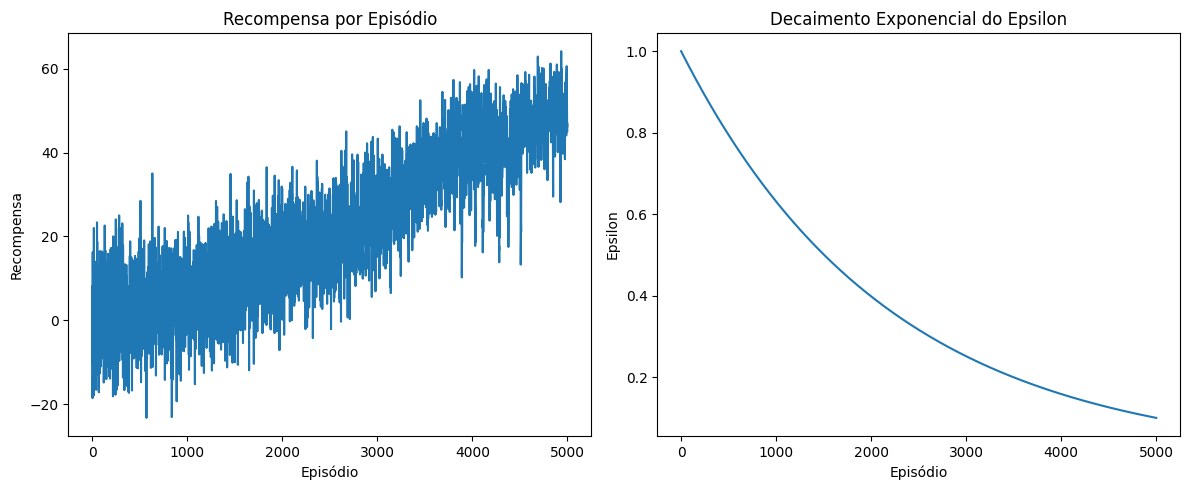

In [9]:
trading_agent.train(episodes = 5000, data_train = data_train, window = 20)

In [10]:
trading_agent.test(10, data_test, window = 20)

Market Return : 128.27%   |   Portfolio Return : 93.17%   |   
[Teste] Episódio 0: Recompensa total = 17.42
Market Return : 128.27%   |   Portfolio Return : 93.15%   |   
[Teste] Episódio 1: Recompensa total = 17.42
Market Return : 128.27%   |   Portfolio Return : 93.13%   |   
[Teste] Episódio 2: Recompensa total = 17.42
Market Return : 128.27%   |   Portfolio Return : 93.15%   |   
[Teste] Episódio 3: Recompensa total = 17.42
Market Return : 128.27%   |   Portfolio Return : 93.17%   |   
[Teste] Episódio 4: Recompensa total = 17.42
Market Return : 128.27%   |   Portfolio Return : 93.13%   |   
[Teste] Episódio 5: Recompensa total = 17.42
Market Return : 128.27%   |   Portfolio Return : 93.15%   |   
[Teste] Episódio 6: Recompensa total = 17.42
Market Return : 128.27%   |   Portfolio Return : 93.13%   |   
[Teste] Episódio 7: Recompensa total = 17.42
Market Return : 128.27%   |   Portfolio Return : 93.17%   |   
[Teste] Episódio 8: Recompensa total = 17.42
Market Return : 128.27%   | 

In [11]:
ticker = "PETR4.SA"
start_date = "2024-06-01"
end_date = "2024-12-01"

data = data_get.from_yfinance( ticker, start_date, end_date )

data_cleaner.cleaning( data )

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume
date,,,,,
2024-06-03,33.804070,34.110741,33.681398,34.023121,43454500
2024-06-04,33.427299,33.672636,33.033006,33.646351,34090200
2024-06-05,33.471111,33.672639,33.357203,33.523682,18627100
2024-06-06,33.628826,33.926737,33.532443,33.541203,25944100
2024-06-07,32.367092,33.707691,32.296997,33.488640,46003600
...,...,...,...,...,...
2024-11-25,36.312729,36.942965,36.284925,36.498093,41119500
2024-11-26,36.266388,36.618576,36.201511,36.479556,35188200
2024-11-27,36.136635,36.479556,35.914197,36.331266,30600700


In [ ]:
data = indicator_adder.add_indicator( data, indicator_name = "rsi", close = data["close"], window = 14 )

data = indicator_adder.add_indicator( data, indicator_name = "sma", close = data["close"], 
                                     window = 14 )

data = indicator_adder.add_indicator( data, indicator_name = "macd", close = data["close"], window_slow=26,
                                      window_fast=12, window_sign=9 )

data = indicator_adder.add_indicator(
    data, 
    indicator_name="bollinger", 
    close=data["close"], 
    window=20,  
    window_dev=2 
)
data["rsi_feature"] = data["rsi"]
data["macd_feature"] = data["macd"]
data["sma_feature"] = data["sma"]
data["bollinger_upper_feature"] = data["bollinger_hband"]
data["bollinger_lower_feature"] = data["bollinger_lband"]

In [13]:
data = data.dropna()
data

Price,close,high,low,open,volume,rsi,sma,macd,macd_signal,macd_diff,bollinger_mavg,bollinger_hband,bollinger_lband,bollinger_width,rsi_feature,macd_feature,sma_feature,bollinger_upper_feature,bollinger_lower_feature
date,,,,,,,,,,,,,,,,,,,
2024-07-18,34.722115,34.839268,34.559904,34.695081,21315500,59.977850,34.454984,0.371335,0.346517,0.024818,34.194932,35.286496,33.103367,6.384363,59.977850,0.371335,34.454984,35.286496,33.103367
2024-07-19,34.866302,34.938398,34.595952,34.695081,30593100,61.597211,34.458846,0.378767,0.352967,0.025800,34.285049,35.281722,33.288376,5.814038,61.597211,0.378767,34.458846,35.281722,33.288376
2024-07-22,34.172401,34.776188,34.136357,34.776188,25807800,50.919449,34.420868,0.324920,0.347358,-0.022437,34.323799,35.236106,33.411492,5.315887,50.919449,0.324920,34.420868,35.236106,33.411492
2024-07-23,33.730827,34.244494,33.730827,34.172399,25284700,45.512630,34.394476,0.243804,0.326647,-0.082842,34.341822,35.190066,33.493578,4.940007,45.512630,0.243804,34.394476,35.190066,33.493578
2024-07-24,34.001179,34.244495,33.793910,33.938097,23863800,49.077760,34.420868,0.199040,0.301126,-0.102085,34.370660,35.126357,33.614963,4.397338,49.077760,0.199040,34.420868,35.126357,33.614963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25,36.312729,36.942965,36.284925,36.498093,41119500,71.072068,34.280348,0.510864,0.149974,0.360890,33.979463,36.239295,31.719631,13.301165,71.072068,0.510864,34.280348,36.239295,31.719631
2024-11-26,36.266388,36.618576,36.201511,36.479556,35188200,70.366848,34.520659,0.582936,0.236566,0.346370,34.117559,36.573458,31.661659,14.396689,70.366848,0.582936,34.520659,36.573458,31.661659
2024-11-27,36.136635,36.479556,35.914197,36.331266,30600700,68.322628,34.758984,0.622409,0.313735,0.308674,34.251948,36.837504,31.666391,15.097282,68.322628,0.622409,34.758984,36.837504,31.666391


In [14]:
trading_agent.test(1, data, window = 20)

Market Return :  5.95%   |   Portfolio Return :  5.93%   |   
[Teste] Episódio 0: Recompensa total = 2.03
